In [1]:
from sklearn.metrics import precision_score, recall_score, fbeta_score, make_scorer, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from scipy.stats import skew
import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import shap
warnings.filterwarnings('ignore')

Chargement des fichiers

In [2]:
eval_df = pd.read_csv("data/extrait_eval.csv")
sirh_df = pd.read_csv("data/extrait_sirh.csv")
sondage_df = pd.read_csv("data/extrait_sondage.csv")

Nettoyage du nom des colonnes

In [3]:
sirh_df = sirh_df.rename(columns={'nombre_heures_travailless' : 'nombre_heures_travaillees', 'annee_experience_totale': 'annees_experience_totale'})


In [4]:
eval_df = eval_df.rename(columns={
  'augementation_salaire_precedente' : 'augmentation_salaire_precedente', 
})

In [5]:
sondage_df = sondage_df.rename(columns={
  'annes_sous_reponsable_actuel' : 'annees_sous_reponsable_actuel'
})

### 1. Un DataFrame central, issu d’une jointure entre les fichiers de départ.


In [6]:
eval_df['id_employee'] = eval_df["eval_number"].str.extract('(\d+)').astype(int)
eval_df.head()

,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,eval_number,note_evaluation_actuelle,heure_supplementaires,augmentation_salaire_precedente,id_employee
0,2,3,2,4,1,1,E_1,3,Oui,11 %,1
1,3,2,2,2,4,3,E_2,4,Non,23 %,2
2,4,2,1,3,2,3,E_4,3,Oui,15 %,4
3,4,3,1,3,3,3,E_5,3,Oui,11 %,5
4,1,3,1,2,4,3,E_7,3,Non,12 %,7


In [7]:
sondage_df['id_employee'] = sondage_df["code_sondage"].replace("00000", "")
sondage_df.head()

,a_quitte_l_entreprise,nombre_participation_pee,nb_formations_suivies,nombre_employee_sous_responsabilite,code_sondage,distance_domicile_travail,niveau_education,domaine_etude,ayant_enfants,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel,id_employee
0,Oui,0,0,1,1,1,2,Infra & Cloud,Y,Occasionnel,0,5,1
1,Non,1,3,1,2,8,1,Infra & Cloud,Y,Frequent,1,7,2
2,Oui,0,3,1,4,2,2,Autre,Y,Occasionnel,0,0,4
3,Non,0,3,1,5,3,4,Infra & Cloud,Y,Frequent,3,0,5
4,Non,1,3,1,7,2,1,Transformation Digitale,Y,Occasionnel,2,2,7


L’utilisation d’une **jointure interne (INNER JOIN)** permet de ne conserver que les employés disposant de données complètes et cohérentes dans les trois fichiers sources.


In [8]:
full_df = sirh_df.merge(eval_df, left_on="id_employee", right_on="id_employee", how="inner").merge(sondage_df, on="id_employee", how="inner")
full_df.head()

,id_employee,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,nombre_heures_travaillees,annees_experience_totale,...,nb_formations_suivies,nombre_employee_sous_responsabilite,code_sondage,distance_domicile_travail,niveau_education,domaine_etude,ayant_enfants,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
0,1,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,80,8,...,0,1,1,1,2,Infra & Cloud,Y,Occasionnel,0,5
1,2,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,80,10,...,3,1,2,8,1,Infra & Cloud,Y,Frequent,1,7
2,4,37,M,2090,Célibataire,Consulting,Consultant,6,80,7,...,3,1,4,2,2,Autre,Y,Occasionnel,0,0
3,5,33,F,2909,Marié(e),Consulting,Assistant de Direction,1,80,8,...,3,1,5,3,4,Infra & Cloud,Y,Frequent,3,0
4,7,27,M,3468,Marié(e),Consulting,Consultant,9,80,6,...,3,1,7,2,1,Transformation Digitale,Y,Occasionnel,2,2


In [9]:
full_df.columns

Index(['id_employee', 'age', 'genre', 'revenu_mensuel', 'statut_marital',
       'departement', 'poste', 'nombre_experiences_precedentes',
       'nombre_heures_travaillees', 'annees_experience_totale',
       'annees_dans_l_entreprise', 'annees_dans_le_poste_actuel',
       'satisfaction_employee_environnement', 'note_evaluation_precedente',
       'niveau_hierarchique_poste', 'satisfaction_employee_nature_travail',
       'satisfaction_employee_equipe',
       'satisfaction_employee_equilibre_pro_perso', 'eval_number',
       'note_evaluation_actuelle', 'heure_supplementaires',
       'augmentation_salaire_precedente', 'a_quitte_l_entreprise',
       'nombre_participation_pee', 'nb_formations_suivies',
       'nombre_employee_sous_responsabilite', 'code_sondage',
       'distance_domicile_travail', 'niveau_education', 'domaine_etude',
       'ayant_enfants', 'frequence_deplacement',
       'annees_depuis_la_derniere_promotion', 'annes_sous_responsable_actuel'],
      dtype='object')

### 2. Des cellules au sein du notebook pour calculer des statistiques descriptives sur les fichiers de départ et le fichier central, dans l’objectif de faire ressortir des différences clés entre les employés.


a. extrait_eval.csv

In [10]:
eval_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 11 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   satisfaction_employee_environnement        1470 non-null   int64 
 1   note_evaluation_precedente                 1470 non-null   int64 
 2   niveau_hierarchique_poste                  1470 non-null   int64 
 3   satisfaction_employee_nature_travail       1470 non-null   int64 
 4   satisfaction_employee_equipe               1470 non-null   int64 
 5   satisfaction_employee_equilibre_pro_perso  1470 non-null   int64 
 6   eval_number                                1470 non-null   object
 7   note_evaluation_actuelle                   1470 non-null   int64 
 8   heure_supplementaires                      1470 non-null   object
 9   augmentation_salaire_precedente            1470 non-null   object
 10  id_employee                         

b. extrait_sirh.csv

In [11]:
sirh_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   id_employee                     1470 non-null   int64 
 1   age                             1470 non-null   int64 
 2   genre                           1470 non-null   object
 3   revenu_mensuel                  1470 non-null   int64 
 4   statut_marital                  1470 non-null   object
 5   departement                     1470 non-null   object
 6   poste                           1470 non-null   object
 7   nombre_experiences_precedentes  1470 non-null   int64 
 8   nombre_heures_travaillees       1470 non-null   int64 
 9   annees_experience_totale        1470 non-null   int64 
 10  annees_dans_l_entreprise        1470 non-null   int64 
 11  annees_dans_le_poste_actuel     1470 non-null   int64 
dtypes: int64(8), object(4)
memory usage: 137.9+ KB


c. extrait_sondage.csv

In [12]:
sondage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   a_quitte_l_entreprise                1470 non-null   object
 1   nombre_participation_pee             1470 non-null   int64 
 2   nb_formations_suivies                1470 non-null   int64 
 3   nombre_employee_sous_responsabilite  1470 non-null   int64 
 4   code_sondage                         1470 non-null   int64 
 5   distance_domicile_travail            1470 non-null   int64 
 6   niveau_education                     1470 non-null   int64 
 7   domaine_etude                        1470 non-null   object
 8   ayant_enfants                        1470 non-null   object
 9   frequence_deplacement                1470 non-null   object
 10  annees_depuis_la_derniere_promotion  1470 non-null   int64 
 11  annes_sous_responsable_actuel        1470 n

d. fichier central 

In [13]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 34 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   id_employee                                1470 non-null   int64 
 1   age                                        1470 non-null   int64 
 2   genre                                      1470 non-null   object
 3   revenu_mensuel                             1470 non-null   int64 
 4   statut_marital                             1470 non-null   object
 5   departement                                1470 non-null   object
 6   poste                                      1470 non-null   object
 7   nombre_experiences_precedentes             1470 non-null   int64 
 8   nombre_heures_travaillees                  1470 non-null   int64 
 9   annees_experience_totale                   1470 non-null   int64 
 10  annees_dans_l_entreprise            

## 3. Identification et nettoyage des colonnes quantitatives et qualitatives

création d'une copie du DataFrame d’origine, conversion de la colonne **`augmentation_salaire_precedente`** en valeurs numériques normalisées entre (0) et (1), puis remplace les réponses qualitatives des colonnes booléennes (**`heure_supplementaires`**, **`a_quitte_l_entreprise`**, **`ayant_enfants`**) par des valeurs binaires 


In [14]:
df_normalized = full_df.copy()

# Variable pourcentage pour pouvoir l'utiliser si besoin
df_normalized['augmentation_salaire_precedente'] = df_normalized['augmentation_salaire_precedente'].apply(
    lambda x: float(x.replace(' %', '')) / 100
)

# Remplacer les 'Oui' et 'Y' en 1 et le reste en 0
bool_columns = ['heure_supplementaires', 'a_quitte_l_entreprise', 'ayant_enfants']
for col in bool_columns:
    df_normalized[col] = df_normalized[col].apply(
        lambda x: 1 if x == 'Oui' or x == 'Y' else 0
    )

df_normalized.head()

,id_employee,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,nombre_heures_travaillees,annees_experience_totale,...,nb_formations_suivies,nombre_employee_sous_responsabilite,code_sondage,distance_domicile_travail,niveau_education,domaine_etude,ayant_enfants,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
0,1,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,80,8,...,0,1,1,1,2,Infra & Cloud,1,Occasionnel,0,5
1,2,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,80,10,...,3,1,2,8,1,Infra & Cloud,1,Frequent,1,7
2,4,37,M,2090,Célibataire,Consulting,Consultant,6,80,7,...,3,1,4,2,2,Autre,1,Occasionnel,0,0
3,5,33,F,2909,Marié(e),Consulting,Assistant de Direction,1,80,8,...,3,1,5,3,4,Infra & Cloud,1,Frequent,3,0
4,7,27,M,3468,Marié(e),Consulting,Consultant,9,80,6,...,3,1,7,2,1,Transformation Digitale,1,Occasionnel,2,2


### Détection et suppression des valeurs aberrantes avec la méthode de l’IQR × 3

Ici, on identifie et supprime les valeurs aberrantes du champ `revenu_mensuel` en utilisant la méthode de l’**écart interquartile (IQR)**.  
L’IQR correspond à la dispersion des données entre le premier quartile \( Q_1 \) (25ᵉ percentile) et le troisième quartile \( Q_3 \) (75ᵉ percentile) :

$$ IQR = Q_3 - Q_1 $$

Une valeur est considérée comme aberrante lorsqu’elle s’écarte excessivement de la zone centrale.  
La méthode applique une **marge de tolérance de 3 × IQR**, ce qui rend la détection **peu agressive** :

$$ \text{Seuil inférieur} = Q_1 - 3 \times IQR $$
$$ \text{Seuil supérieur} = Q_3 + 3 \times IQR $$

Les observations situées en dehors de cet intervalle sont supprimées pour éviter que des valeurs extrêmes ne perturbent les statistiques descriptives ou les modèles d’apprentissage.


In [15]:
Q1 = df_normalized['revenu_mensuel'].quantile(0.25)
Q3 = df_normalized['revenu_mensuel'].quantile(0.75)
IQR = Q3 - Q1

seuil_inferieur = max(Q1 - 3 * IQR, 0)
seuil_superieur = Q3 + 3 * IQR

outliers_mask = (df_normalized['revenu_mensuel'] < seuil_inferieur) | \
                (df_normalized['revenu_mensuel'] > seuil_superieur)
df_normalized = df_normalized[~outliers_mask].copy()

In [16]:
df_normalized.describe()

,id_employee,age,revenu_mensuel,nombre_experiences_precedentes,nombre_heures_travaillees,annees_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel,satisfaction_employee_environnement,note_evaluation_precedente,...,a_quitte_l_entreprise,nombre_participation_pee,nb_formations_suivies,nombre_employee_sous_responsabilite,code_sondage,distance_domicile_travail,niveau_education,ayant_enfants,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000
mean,1024.865306,36.923810,6502.931293,2.693197,80.0,11.279592,7.008163,4.229252,2.721769,2.729932,...,0.161224,0.793878,2.799320,1.0,1024.865306,9.192517,2.912925,1.0,2.187755,4.123129
std,602.024335,9.135373,4707.956783,2.498009,0.0,7.780782,6.126525,3.623137,1.093082,0.711561,...,0.367863,0.852077,1.289271,0.0,602.024335,8.106864,1.024165,0.0,3.222430,3.568136
min,1.000000,18.000000,1009.000000,0.000000,80.0,0.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,1.0,1.000000,1.000000,1.000000,1.0,0.000000,0.000000
25%,491.250000,30.000000,2911.000000,1.000000,80.0,6.000000,3.000000,2.000000,2.000000,2.000000,...,0.000000,0.000000,2.000000,1.0,491.250000,2.000000,2.000000,1.0,0.000000,2.000000
50%,1020.500000,36.000000,4919.000000,2.000000,80.0,10.000000,5.000000,3.000000,3.000000,3.000000,...,0.000000,1.000000,3.000000,1.0,1020.500000,7.000000,3.000000,1.0,1.000000,3.000000
75%,1555.750000,43.000000,8379.000000,4.000000,80.0,15.000000,9.000000,7.000000,4.000000,3.000000,...,0.000000,1.000000,3.000000,1.0,1555.750000,14.000000,4.000000,1.0,3.000000,7.000000
max,2068.000000,60.000000,19999.000000,9.000000,80.0,40.000000,40.000000,18.000000,4.000000,4.000000,...,1.000000,3.000000,6.000000,1.0,2068.000000,29.000000,5.000000,1.0,15.000000,17.000000


Identification des types de variables dans le DataFrame normalisé :

* **Variables quantitatives** : colonnes de type numérique (`int64`, `float64`), destinées aux calculs et analyses statistiques.
* **Variables qualitatives** : colonnes de type texte (`object`), correspondant à des catégories ou libellés.

Cette identification permet d’adapter les traitements selon la nature des données.


In [17]:
colonnes_quantitatives = df_normalized.select_dtypes(include=['int64', 'float64']).columns.tolist()
colonnes_qualitatives = df_normalized.select_dtypes(include=['object']).columns.tolist()

print(f"Colonnes quantitatives ({len(colonnes_quantitatives)}): {colonnes_quantitatives}")
print(f"Colonnes qualitatives ({len(colonnes_qualitatives)}): {colonnes_qualitatives}")

Colonnes quantitatives (27): ['id_employee', 'age', 'revenu_mensuel', 'nombre_experiences_precedentes', 'nombre_heures_travaillees', 'annees_experience_totale', 'annees_dans_l_entreprise', 'annees_dans_le_poste_actuel', 'satisfaction_employee_environnement', 'note_evaluation_precedente', 'niveau_hierarchique_poste', 'satisfaction_employee_nature_travail', 'satisfaction_employee_equipe', 'satisfaction_employee_equilibre_pro_perso', 'note_evaluation_actuelle', 'heure_supplementaires', 'augmentation_salaire_precedente', 'a_quitte_l_entreprise', 'nombre_participation_pee', 'nb_formations_suivies', 'nombre_employee_sous_responsabilite', 'code_sondage', 'distance_domicile_travail', 'niveau_education', 'ayant_enfants', 'annees_depuis_la_derniere_promotion', 'annes_sous_responsable_actuel']
Colonnes qualitatives (7): ['genre', 'statut_marital', 'departement', 'poste', 'eval_number', 'domaine_etude', 'frequence_deplacement']


Création de **boxplots** pour les variables quantitatives principales.
Chaque graphique illustre la **distribution**, la **médiane** et les **valeurs extrêmes** de chaque variable, facilitant la détection des **outliers** et l’analyse de la dispersion des données.


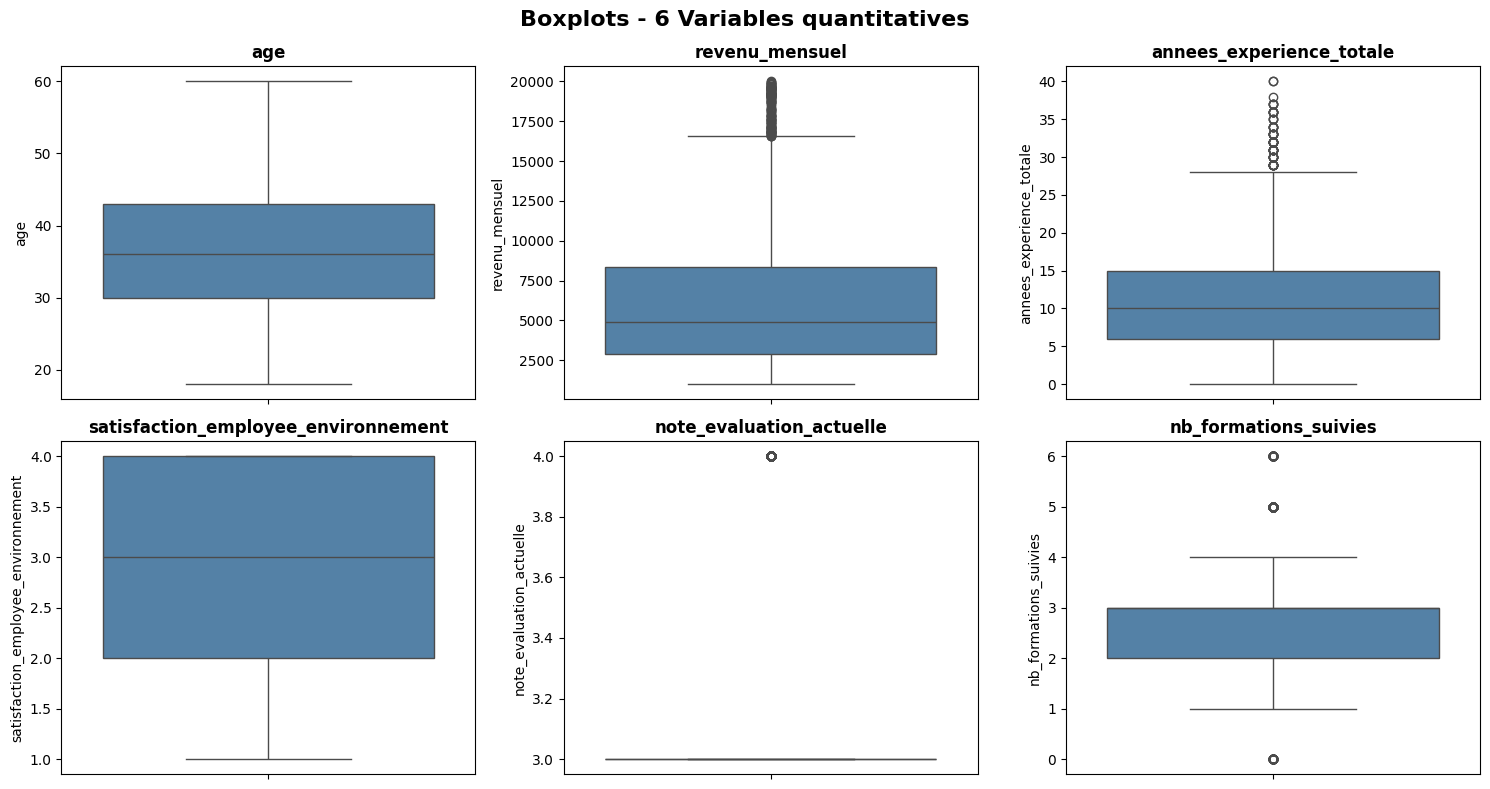

In [18]:
vars_principales = ['age', 'revenu_mensuel', 'annees_experience_totale', 
                   'satisfaction_employee_environnement', 'note_evaluation_actuelle',
                   'nb_formations_suivies']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Boxplots - 6 Variables quantitatives', 
             fontsize=16, fontweight='bold')

for i, var in enumerate(vars_principales):
    row = i // 3
    col = i % 3
    
    sns.boxplot(data=df_normalized, y=var, ax=axes[row, col], color='steelblue')
    axes[row, col].set_title(f'{var}', fontweight='bold')

plt.tight_layout()
plt.show()

## Feature Engineering

In [ ]:
df_engineered = df_normalized.copy()

# 1. Ratio expérience 
df_engineered['experience_ratio'] = df_engineered['annees_experience_totale'] / (df_engineered['age'] + 1)

# 2. Age au carré 
df_engineered['age_squared'] = df_engineered['age'] ** 2

# 3. Interaction satisfaction
df_engineered['satisfaction_equilibre'] = (
    df_engineered['satisfaction_employee_nature_travail'] * 
    df_engineered['satisfaction_employee_equilibre_pro_perso']
)

# 4. Ratio au carré
df_engineered['experience_ratio_squared'] = df_engineered['experience_ratio'] ** 2

# 5. Mobilité ratio
df_engineered['mobilite_ratio'] = df_engineered['annees_dans_le_poste_actuel'] / (df_engineered['annees_dans_l_entreprise'] + 1)

# 6. Revenu par expérience
df_engineered['revenu_par_experience'] = df_engineered['revenu_mensuel'] / (df_engineered['annees_experience_totale'] + 1)

In [20]:
df_engineered.head()

,id_employee,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,nombre_heures_travaillees,annees_experience_totale,...,ayant_enfants,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel,experience_ratio,age_squared,satisfaction_equilibre,experience_ratio_squared,mobilite_ratio,revenu_par_experience
0,1,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,80,8,...,1,Occasionnel,0,5,0.190476,1681,4,0.036281,0.571429,665.888889
1,2,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,80,10,...,1,Frequent,1,7,0.200000,2401,6,0.040000,0.636364,466.363636
2,4,37,M,2090,Célibataire,Consulting,Consultant,6,80,7,...,1,Occasionnel,0,0,0.184211,1369,9,0.033934,0.000000,261.250000
3,5,33,F,2909,Marié(e),Consulting,Assistant de Direction,1,80,8,...,1,Frequent,3,0,0.235294,1089,9,0.055363,0.777778,323.222222
4,7,27,M,3468,Marié(e),Consulting,Consultant,9,80,6,...,1,Occasionnel,2,2,0.214286,729,6,0.045918,0.666667,495.428571


## Validation globale de la qualité des données

1. **Recherche de doublons** : compte le nombre de lignes répétées dans les trois fichiers.
2. **Salaires négatifs** : identifie les enregistrements où `revenu_mensuel` est inférieur à 0.
3. **Âge d’embauche incohérent** : calcule l’âge à l’embauche (`age - annees_dans_l_entreprise`) et détecte les cas inférieurs à 18 ans.
4. **Incohérences temporelles** : vérifie que `annees_dans_l_entreprise` ne dépasse pas l’âge de l’employé, ce qui indiquerait une erreur dans les données.


In [21]:
# Recherche des doublons
print("\n1. Recherche des doublons :")
print(f"   - SIRH: {sirh_df.duplicated().sum()}")
print(f"   - Évaluation: {eval_df.duplicated().sum()}")
print(f"   - Sondage: {sondage_df.duplicated().sum()}")

# Détection des salaires négatifs
if 'revenu_mensuel' in sirh_df.columns:
    salaires_negatifs = (sirh_df['revenu_mensuel'] < 0).sum()
    print(f"\n2. Salaires négatifs: {salaires_negatifs}")

# Vérification si première année d'expérience < 18
if all(col in sirh_df.columns for col in ['age', 'annees_dans_l_entreprise']):
    age_embauche = sirh_df['age'] - sirh_df['annees_dans_l_entreprise']
    probleme_age = (age_embauche < 18).sum()
    print(f"\n3. Employés embauchés avant 18 ans: {probleme_age}")

# Âge supérieur à l'âge d'entrée en entreprise + années d'entreprise
if all(col in sirh_df.columns for col in ['age', 'annees_dans_l_entreprise']):
    incoherence_temporelle = (sirh_df['annees_dans_l_entreprise'] > sirh_df['age']).sum()
    print(f"\n4. Incohérences temporelles: {incoherence_temporelle}")


1. Recherche des doublons :
   - SIRH: 0
   - Évaluation: 0
   - Sondage: 0

2. Salaires négatifs: 0

3. Employés embauchés avant 18 ans: 0

4. Incohérences temporelles: 0


## 4. Construction des modèles de baseline

### Preprocessing des données

* Crée une copie de `df_engineered` dans `df_model`.
* Supprime les colonnes inutiles ou identifiants (`eval_number`, `code_sondage`, `id_employee`) pour éviter les fuites d’information.
* Définit la variable cible `y` correspondant à `a_quitte_l_entreprise`.
* Définit `X` contenant toutes les autres features du modèle.
* Affiche le **nombre de features**, d’**observations** et la liste des colonnes utilisées pour l’entraînement.


In [22]:
df_model = df_engineered.copy()

colonnes_a_supprimer = ['eval_number', 'code_sondage', 'id_employee']
df_model = df_model.drop(columns=colonnes_a_supprimer)

target = 'a_quitte_l_entreprise'
y = df_model[target]

X = df_model.drop(columns=[target])

print(f"Nombre de features: {X.shape[1]}")
print(f"Nombre d'observations: {X.shape[0]}")

Nombre de features: 36
Nombre d'observations: 1470


### Construction dynamique d’un pipeline de prétraitement des données

Ici, un pipeline de prétraitement est généré automatiquement selon le type de modèle choisi.  
L’objectif est de normaliser les données numériques, d’encoder les variables catégorielles et d’appliquer éventuellement une transformation logarithmique sur les valeurs continues.

#### Transformation logarithmique sécurisée
Une transformation log est appliquée uniquement sur les valeurs positives afin de réduire l'asymétrie des distributions numériques :

$$ x' = \log(1 + x), \quad \text{pour } x \geq 0 $$

Cette étape stabilise la variance et rend la distribution plus proche d’une loi normale, ce qui favorise les modèles linéaires comme la régression logistique.

#### Pipeline numérique
- Pour un modèle **logistique**, les variables numériques peuvent être transformées par log, puis normalisées avec un `StandardScaler`, garantissant une moyenne nulle et un écart-type unitaire.  
- Pour les modèles **à base d’arbres** (`tree`, `random_forest`, `xgboost`), la normalisation est inutile ; seule la transformation log peut être appliquée ou contournée.

#### Pipeline catégoriel
Les variables catégorielles sont encodées selon la stratégie choisie :
- **`ordinal_onehot`** : encodage ordinal suivi d’un one-hot encoding pour capter les relations et éviter les collisions entre catégories.  
- **`onehot`** : encodage binaire pur.  
- **`ordinal`** : encodage par ordre numérique simple, adapté aux modèles d’arbres.

#### Assemblage global
L’ensemble est combiné via un `ColumnTransformer` pour appliquer les bons traitements sur chaque type de colonne.  
Les données transformées sont ensuite renvoyées prêtes pour l’entraînement et le test, selon le type de modèle :

- `pipeline_lr` : prétraitement adapté à un modèle **logistique**.  
- `pipeline_tree` : prétraitement adapté à un modèle **Decision Tree** ou **Random Forest**.


In [23]:
def create_preprocessing_pipeline(model_type, numerical_cols, categorical_cols, 
                                   use_log=True, categorical_encoding='ordinal_onehot'):
    def safe_log_transform(X):
        X_copy = X.copy()
        mask = X_copy >= 0
        X_copy[mask] = np.log1p(X_copy[mask])
        return X_copy
    
    log_transformer = FunctionTransformer(safe_log_transform, validate=False)
    
    if model_type == 'logistic':
        if use_log:
            numerical_transformer = Pipeline(steps=[
                ('log', log_transformer),
                ('scaler', StandardScaler())
            ])
        else:
            numerical_transformer = StandardScaler()
    elif model_type in ['tree', 'random_forest', 'xgboost']:
        if use_log:
            numerical_transformer = log_transformer
        else:
            numerical_transformer = 'passthrough'

    if categorical_encoding == 'ordinal_onehot':
        categorical_transformer = Pipeline(steps=[
            ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
            ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
        ])
    elif categorical_encoding == 'onehot':
        categorical_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    elif categorical_encoding == 'ordinal':
        categorical_transformer = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])
    
    return preprocessor


def get_preprocessed_data(X_train, X_test, model_type='logistic', encoding_strategy='mixed'):

    X_train_copy = X_train.copy()
    X_test_copy = X_test.copy()

    numerical_cols = X_train_copy.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = X_train_copy.select_dtypes(exclude=[np.number]).columns.tolist()
    
    encoding_map = {
        'mixed': 'ordinal_onehot',
        'onehot': 'onehot',
        'ordinal': 'ordinal'
    }
    categorical_encoding = encoding_map.get(encoding_strategy, 'ordinal_onehot')
    
    pipeline = create_preprocessing_pipeline(model_type, numerical_cols, categorical_cols, 
                                            use_log=True, categorical_encoding=categorical_encoding)
    X_train_transformed = pipeline.fit_transform(X_train_copy)
    X_test_transformed = pipeline.transform(X_test_copy)
    return X_train_transformed, X_test_transformed, pipeline


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_lr, X_test_lr, pipeline_lr = get_preprocessed_data(
    X_train, X_test, model_type='logistic'
)

X_train_tree, X_test_tree, pipeline_tree = get_preprocessed_data(
    X_train, X_test, model_type='tree', encoding_strategy='mixed'
)


### Gestion du déséquilibre des classes et évaluation des modèles

#### Stratégies pour gérer le déséquilibre

Pour gérer le déséquilibre des classes, nous utilisons :
- **`class_weight='balanced'`** pour Logistic Regression et Random Forest : ajuste automatiquement les poids des classes inversement proportionnels à leurs fréquences
- **`scale_pos_weight`** pour XGBoost : compense le déséquilibre entre classes

#### Calcul du `scale_pos_weight` pour XGBoost
Pour les modèles sensibles au déséquilibre, notamment **XGBoost**, le paramètre `scale_pos_weight` compense le déséquilibre entre classes :

$$
\text{scale\_pos\_weight} = \frac{\text{nombre d'exemples négatifs}}{\text{nombre d'exemples positifs}}
$$

In [24]:

def calculate_scale_pos_weight(y_train):
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    return scale_pos_weight


def train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name, beta=2):
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    return model, y_pred, y_proba


def find_optimal_threshold(y_proba, y_true, beta=2):
    thresholds = np.linspace(0.1, 0.9, 50)
    fbeta_scores = []

    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        fbeta = fbeta_score(y_true, y_pred, beta=beta)
        fbeta_scores.append(fbeta)

    best_idx = np.argmax(fbeta_scores)
    optimal_threshold = thresholds[best_idx]
    best_fbeta = fbeta_scores[best_idx]

    return optimal_threshold, best_fbeta


#### Dummy :

In [25]:
dummy_clf = DummyClassifier(strategy='stratified', random_state=42)
dummy_clf.fit(X_train_lr, y_train)

dummy_pred = dummy_clf.predict(X_test_lr)
dummy_proba = dummy_clf.predict_proba(X_test_lr)[:, 1]

print(f"Fbeta-Score: {fbeta_score(y_test, dummy_pred, beta=2)}")
print(f"Precision: {precision_score(y_test, dummy_pred)}")
print(f"Recall: {recall_score(y_test, dummy_pred)}")

Fbeta-Score: 0.12658227848101267
Precision: 0.12244897959183673
Recall: 0.1276595744680851


#### Logistic Regression

In [26]:
logistic_clf = LogisticRegression(random_state=42, max_iter=1000, class_weight="balanced")

logistic_clf, logistic_pred, logistic_proba = train_and_evaluate(
    logistic_clf, 
    X_train_lr, 
    y_train, 
    X_test_lr, 
    y_test, 
    "Logistic Regression"
)

#### XGBoost

In [27]:

xgb_clf = xgb.XGBClassifier(random_state=42, eval_metric='logloss', scale_pos_weight=5)

xgb_clf, xgb_pred, xgb_proba = train_and_evaluate(
    xgb_clf, 
    X_train_tree,  
    y_train, 
    X_test_tree, 
    y_test, 
    "Xgboost"
)

#### Random Forest

In [28]:
rf_clf = RandomForestClassifier(
    n_estimators=500,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
)

rf_clf, rf_pred, rf_proba = train_and_evaluate(
    rf_clf, 
    X_train_tree,  
    y_train, 
    X_test_tree, 
    y_test, 
    "Random Forest"
)

### Mètriques principales :

- **FBeta-Score (beta=2)** : favorise le rappel, utile dans les contextes où détecter les positifs est prioritaire.
- **Précision** : proportion de prédictions positives correctes.
- **Rappel** : proportion de vraies positives correctement identifiées.


In [29]:
results = pd.DataFrame({
    'Modèle': ['Dummy', 'Logistic Regression', 'Random Forest', 'XGBoost'],
    'FBeta-Score': [
        fbeta_score(y_test, dummy_pred, beta=2),
        fbeta_score(y_test, logistic_pred, beta=2),
        fbeta_score(y_test, rf_pred, beta=2),
        fbeta_score(y_test, xgb_pred, beta=2)
    ],
    'Precision': [
        precision_score(y_test, dummy_pred),
        precision_score(y_test, logistic_pred),
        precision_score(y_test, rf_pred),
        precision_score(y_test, xgb_pred)
    ],
    'Recall': [
        recall_score(y_test, dummy_pred),
        recall_score(y_test, logistic_pred),
        recall_score(y_test, rf_pred),
        recall_score(y_test, xgb_pred)
    ]
})


### Visualisation des Faux Positifs et Vrais Positifs

Les matrices de confusion permettent d’analyser la qualité des prédictions en détaillant quatre types d’issues :

- **Vrais Positifs (VP)** : observations positives correctement prédites comme positives. 
- **Faux Positifs (FP)** : observations négatives prédites à tort comme positives.
- **Vrais Négatifs (VN)** : observations négatives correctement prédites comme négatives.  
- **Faux Négatifs (FN)** : observations positives prédites à tort comme négatives.




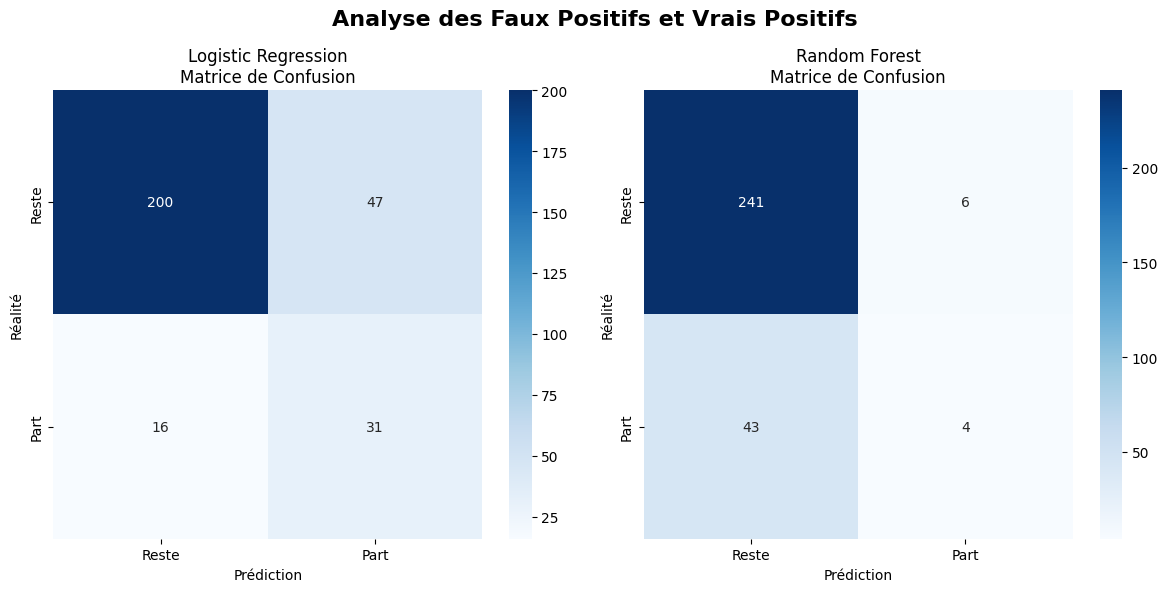

In [30]:
plt.style.use('default')
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Analyse des Faux Positifs et Vrais Positifs', fontsize=16, fontweight='bold')

models = {
    'Logistic Regression': logistic_pred,
    'Random Forest': rf_pred
}

for i, (name, pred) in enumerate(models.items()):
    cm = confusion_matrix(y_test, pred)
   
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Reste', 'Part'],
                yticklabels=['Reste', 'Part'],
                ax=axes[i])
    axes[i].set_title(f'{name}\nMatrice de Confusion')
    axes[i].set_xlabel('Prédiction')
    axes[i].set_ylabel('Réalité')

plt.tight_layout()
plt.show()

- Utilise **StratifiedKFold** (5 folds) pour conserver la proportion de classes dans chaque fold.
- Utilise **`class_weight='balanced'`** pour Logistic Regression et Random Forest, et **`scale_pos_weight`** pour XGBoost pour gérer le déséquilibre des classes.
- Les modèles évalués : **Dummy**, **Logistic Regression**, **Random Forest**, **XGBoost**.
- Pour chaque fold :
  - Entraîne le modèle sur l'ensemble d'entraînement du fold.
  - Prédit sur l'ensemble de validation du fold.
  - Calcule **FBeta-Score (β=2)**, **Précision** et **Recall**.



**Interprétation du coefficient de variation (CV) :**
- CV < 0.10 : Très stable
- 0.10 ≤ CV < 0.20 : Stable  
- 0.20 ≤ CV < 0.30 : Modérément stable
- CV ≥ 0.30 : Instable


In [31]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
beta = 2

models = {
    'Dummy': (DummyClassifier(strategy='stratified', random_state=42), X_train_lr),
    'Logistic Regression': (LogisticRegression(random_state=42, max_iter=1000, class_weight="balanced"), X_train_lr),
    'Random Forest': (RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1, class_weight="balanced"), X_train_tree),
    'XGBoost': (xgb.XGBClassifier(random_state=42, eval_metric='logloss', scale_pos_weight=5), X_train_tree)
}

cv_results = {
    'model': [],
    'fold': [],
    'fbeta_score': [],
    'precision': [],
    'recall': []
}

for model_name, (model, X_data) in models.items():
    print(f"\n{model_name}")
    for fold, (train_idx, val_idx) in enumerate(cv.split(X_data, y_train)):

        X_cv_train, X_cv_val = X_data[train_idx], X_data[val_idx]
        y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_cv_train, y_cv_train)
        y_pred = model.predict(X_cv_val)

        fbeta = fbeta_score(y_cv_val, y_pred, beta=beta, zero_division=0)
        precision = precision_score(y_cv_val, y_pred, zero_division=0)
        recall = recall_score(y_cv_val, y_pred, zero_division=0)

        cv_results['model'].append(model_name)
        cv_results['fold'].append(fold + 1)
        cv_results['fbeta_score'].append(fbeta)
        cv_results['precision'].append(precision)
        cv_results['recall'].append(recall)
        
        print(f"  Fold {fold + 1}: FBeta={fbeta:.3f}, Precision={precision:.3f}, Recall={recall:.3f}")

cv_df = pd.DataFrame(cv_results)


Dummy
  Fold 1: FBeta=0.160, Precision=0.171, Recall=0.158
  Fold 2: FBeta=0.160, Precision=0.171, Recall=0.158
  Fold 3: FBeta=0.134, Precision=0.143, Recall=0.132
  Fold 4: FBeta=0.214, Precision=0.229, Recall=0.211
  Fold 5: FBeta=0.134, Precision=0.143, Recall=0.132

Logistic Regression
  Fold 1: FBeta=0.664, Precision=0.475, Recall=0.737
  Fold 2: FBeta=0.610, Precision=0.426, Recall=0.684
  Fold 3: FBeta=0.652, Precision=0.385, Recall=0.789
  Fold 4: FBeta=0.686, Precision=0.419, Recall=0.816
  Fold 5: FBeta=0.636, Precision=0.412, Recall=0.737

Random Forest
  Fold 1: FBeta=0.159, Precision=1.000, Recall=0.132
  Fold 2: FBeta=0.126, Precision=0.571, Recall=0.105
  Fold 3: FBeta=0.280, Precision=1.000, Recall=0.237
  Fold 4: FBeta=0.219, Precision=0.875, Recall=0.184
  Fold 5: FBeta=0.327, Precision=0.688, Recall=0.289

XGBoost
  Fold 1: FBeta=0.491, Precision=0.810, Recall=0.447
  Fold 2: FBeta=0.371, Precision=0.565, Recall=0.342
  Fold 3: FBeta=0.460, Precision=0.727, Recall=

In [32]:
cv_df = pd.DataFrame(cv_results)

def calculate_cv(group):
    cv_dict = {}
    for metric in ['fbeta_score', 'precision', 'recall']:
        mean_val = group[metric].mean()
        std_val = group[metric].std()
        cv_dict[f'{metric}_cv'] = (std_val / mean_val) if mean_val > 0 else 0
    return pd.Series(cv_dict)

cv_stability = cv_df.groupby('model').apply(calculate_cv).round(4)

cv_stability


,fbeta_score_cv,precision_cv,recall_cv
model,,,
Dummy,0.2041,0.2041,0.2041
Logistic Regression,0.0437,0.0773,0.0682
Random Forest,0.3741,0.2318,0.3977
XGBoost,0.1165,0.1610,0.1338


### Récupération des métriques par modèle depuis les résultats de CV

In [33]:

model_metrics = {}
for model_name in ['Logistic Regression', 'Random Forest', 'XGBoost']:
    # Métriques CV
    cv_model_data = cv_df[cv_df['model'] == model_name]
    fbeta_mean = cv_model_data['fbeta_score'].mean()
    fbeta_std = cv_model_data['fbeta_score'].std()
    precision_mean = cv_model_data['precision'].mean()
    recall_mean = cv_model_data['recall'].mean()
    
    cv_coeff = (fbeta_std / fbeta_mean) if fbeta_mean > 0 else 0
    
    model_metrics[model_name] = {
        'cv_fbeta_mean': fbeta_mean,
        'cv_fbeta_std': fbeta_std,
        'cv_precision_mean': precision_mean,
        'cv_recall_mean': recall_mean,
        'cv_coefficient': cv_coeff
    }


### Visualisation des performances et de la stabilité des modèles

#### Comparaison des métriques
- **Barres groupées** représentant le **F-Beta Score**, la **Précision** et le **Rappel** pour chaque modèle.  
- Permet d’identifier rapidement le modèle ayant les meilleures performances globales.

#### Stabilité des modèles
- Le **Coefficient de Variation (CV)** mesure la variabilité relative des métriques entre les plis de validation croisée :

$$ CV = \frac{\sigma}{\mu} $$

- Des lignes de référence indiquent les seuils de stabilité, facilitant l’évaluation rapide de la robustesse des modèles.


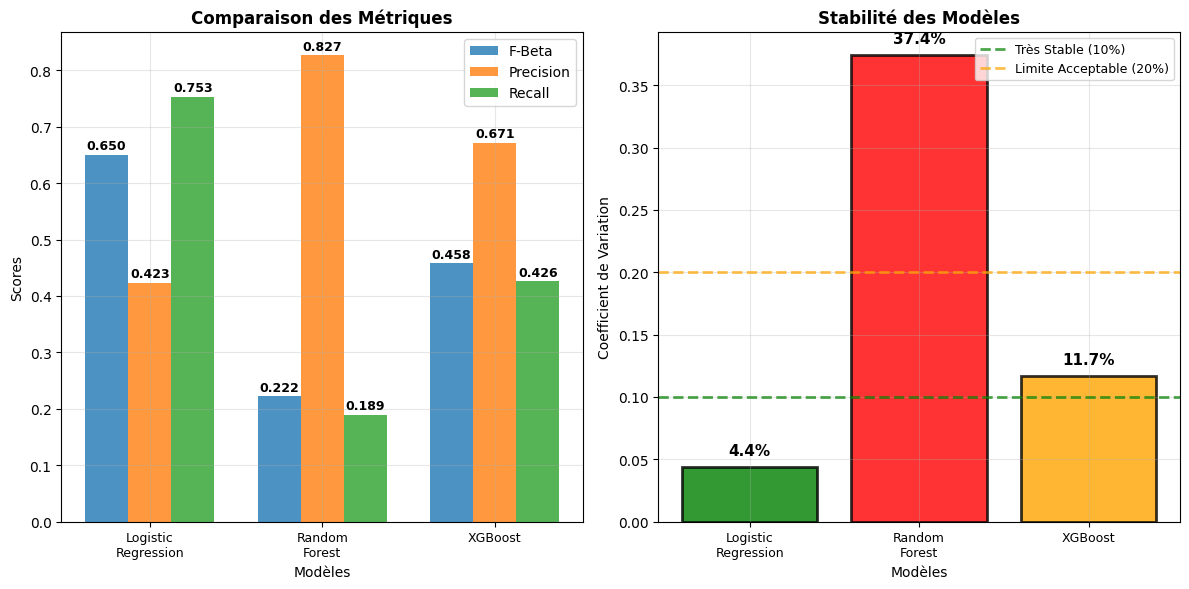

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

colors = ['#2E8B57', '#FF6B6B', '#4ECDC4']  
models = ['Logistic Regression', 'Random Forest', 'XGBoost']
model_names = list(model_metrics.keys())

ax = axes[0]
x = np.arange(len(model_names))
width = 0.25

fbeta_scores = [model_metrics[m]['cv_fbeta_mean'] for m in model_names]
precision_scores = [model_metrics[m]['cv_precision_mean'] for m in model_names]
recall_scores = [model_metrics[m]['cv_recall_mean'] for m in model_names]

bars1 = ax.bar(x - width, fbeta_scores, width, label='F-Beta', color='#1f77b4', alpha=0.8)
bars2 = ax.bar(x, precision_scores, width, label='Precision', color='#ff7f0e', alpha=0.8)
bars3 = ax.bar(x + width, recall_scores, width, label='Recall', color='#2ca02c', alpha=0.8)

for i, (fb, pr, rc) in enumerate(zip(fbeta_scores, precision_scores, recall_scores)):
    ax.text(i - width, fb + 0.01, f'{fb:.3f}', ha='center', fontsize=9, fontweight='bold')
    ax.text(i, pr + 0.01, f'{pr:.3f}', ha='center', fontsize=9, fontweight='bold')
    ax.text(i + width, rc + 0.01, f'{rc:.3f}', ha='center', fontsize=9, fontweight='bold')

ax.set_xlabel('Modèles')
ax.set_ylabel('Scores')
ax.set_title('Comparaison des Métriques', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([name.replace(' ', '\n') for name in model_names], fontsize=9)
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1]
cvs = [model_metrics[m]['cv_coefficient'] for m in model_names]
colors_stability = ['green' if cv < 0.10 else 'orange' if cv < 0.20 else 'red' for cv in cvs]

bars = ax.bar(range(len(model_names)), cvs,
              color=colors_stability, alpha=0.8, edgecolor='black', linewidth=2)

for i, cv in enumerate(cvs):
    ax.text(i, cv + 0.01, f'{cv:.1%}',
            ha='center', fontsize=11, fontweight='bold')

ax.axhline(y=0.10, color='green', linestyle='--', alpha=0.7, linewidth=2, label='Très Stable (10%)')
ax.axhline(y=0.20, color='orange', linestyle='--', alpha=0.7, linewidth=2, label='Limite Acceptable (20%)')

ax.set_xlabel('Modèles')
ax.set_ylabel('Coefficient de Variation')
ax.set_title('Stabilité des Modèles', fontweight='bold')
ax.set_xticks(range(len(model_names)))
ax.set_xticklabels([name.replace(' ', '\n') for name in model_names], fontsize=9)
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Comparaison des modèles avec ajustement de seuil optimal

Ce code compare les modèles sur le **jeu de test** en ajustant le **seuil de classification**, ce qui est crucial lorsque la **classe positive est minoritaire** :

- Pour chaque modèle (`Logistic Regression`, `Random Forest`, `XGBoost`) :

  - On récupère les **probabilités prédites** pour la classe positive.
  - On teste une **plage de seuils** (`0.05` à `0.95`) pour convertir les probabilités en prédictions binaires.
  - Pour chaque seuil, on calcule **FBeta-Score (β=2)**, **Précision** et **Recall**.
  - Le **seuil optimal** est celui qui maximise le FBeta-Score, équilibrant rappel et précision selon l’importance des faux négatifs.

L’ajustement du seuil permet de **contrôler le compromis entre sensibilité et précision**, essentiel dans un contexte où détecter correctement les départs d’employés est plus important que limiter les faux positifs.


In [35]:
models_comparison = []
best_thresholds = {}

models_dict = {
    'Logistic Regression': (logistic_clf, logistic_proba),
    'Random Forest': (rf_clf, rf_proba),
    'XGBoost': (xgb_clf, xgb_proba)
}

for model_name, (model, probas) in models_dict.items():
    optimal_threshold, best_fbeta = find_optimal_threshold(probas, y_test, beta=2)

    y_pred_optimal = (probas >= optimal_threshold).astype(int)
    precision = precision_score(y_test, y_pred_optimal, zero_division=0)
    recall = recall_score(y_test, y_pred_optimal, zero_division=0)

    best_thresholds[model_name] = optimal_threshold

    models_comparison.append({
        'Modèle': model_name,
        'Seuil optimal': optimal_threshold,
        'F-Beta Score': best_fbeta,
        'Precision': precision,
        'Recall': recall
    })

comparison_df = pd.DataFrame(models_comparison)



### Comparaison des modèles avec ajustement de seuil optimal

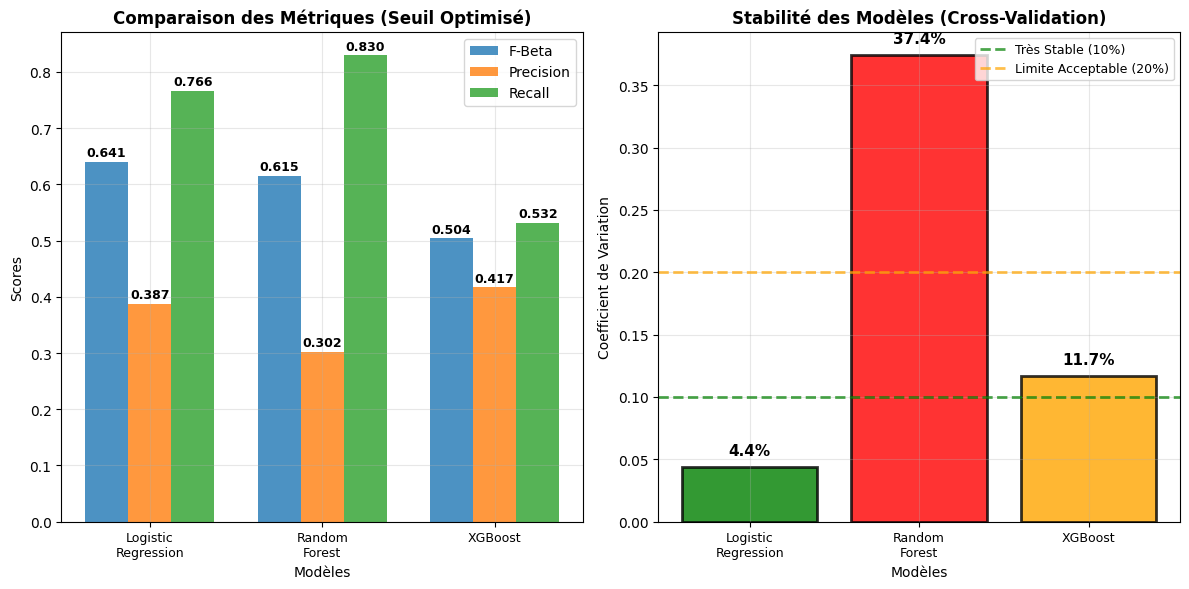

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

model_names = [m['Modèle'] for m in models_comparison]

ax = axes[0]
x = np.arange(len(model_names))
width = 0.25

fbeta_scores = [m['F-Beta Score'] for m in models_comparison]
precision_scores = [m['Precision'] for m in models_comparison]
recall_scores = [m['Recall'] for m in models_comparison]

bars1 = ax.bar(x - width, fbeta_scores, width, label='F-Beta', color='#1f77b4', alpha=0.8)
bars2 = ax.bar(x, precision_scores, width, label='Precision', color='#ff7f0e', alpha=0.8)
bars3 = ax.bar(x + width, recall_scores, width, label='Recall', color='#2ca02c', alpha=0.8)

for i, (fb, pr, rc) in enumerate(zip(fbeta_scores, precision_scores, recall_scores)):
    ax.text(i - width, fb + 0.01, f'{fb:.3f}', ha='center', fontsize=9, fontweight='bold')
    ax.text(i, pr + 0.01, f'{pr:.3f}', ha='center', fontsize=9, fontweight='bold')
    ax.text(i + width, rc + 0.01, f'{rc:.3f}', ha='center', fontsize=9, fontweight='bold')

ax.set_xlabel('Modèles')
ax.set_ylabel('Scores')
ax.set_title('Comparaison des Métriques (Seuil Optimisé)', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([name.replace(' ', '\n') for name in model_names], fontsize=9)
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1]
cvs = []
for model_name in model_names:
    if model_name in model_metrics:
        cvs.append(model_metrics[model_name]['cv_coefficient'])
    elif 'Logistic' in model_name:
        cvs.append(model_metrics['Logistic Regression']['cv_coefficient'])
    elif 'Random' in model_name:
        cvs.append(model_metrics['Random Forest']['cv_coefficient'])
    elif 'XGBoost' in model_name:
        cvs.append(model_metrics['XGBoost']['cv_coefficient'])
    else:
        cvs.append(0) 

colors_stability = ['green' if cv < 0.10 else 'orange' if cv < 0.20 else 'red' for cv in cvs]

bars = ax.bar(range(len(model_names)), cvs,
              color=colors_stability, alpha=0.8, edgecolor='black', linewidth=2)

for i, cv in enumerate(cvs):
    ax.text(i, cv + 0.01, f'{cv:.1%}',
            ha='center', fontsize=11, fontweight='bold')

ax.axhline(y=0.10, color='green', linestyle='--', alpha=0.7, linewidth=2, label='Très Stable (10%)')
ax.axhline(y=0.20, color='orange', linestyle='--', alpha=0.7, linewidth=2, label='Limite Acceptable (20%)')

ax.set_xlabel('Modèles')
ax.set_ylabel('Coefficient de Variation')
ax.set_title('Stabilité des Modèles (Cross-Validation)', fontweight='bold')
ax.set_xticks(range(len(model_names)))
ax.set_xticklabels([name.replace(' ', '\n') for name in model_names], fontsize=9)
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## GridSearch pour Random Forest

* `param_grid` définit les combinaisons d'hyperparamètres à tester : nombre d'arbres, profondeur maximale, nombre minimal d'échantillons pour diviser ou feuille, fraction de features et d'échantillons, etc.
* `GridSearchCV` réalise une **validation croisée stratifiée** pour chaque combinaison et évalue les modèles avec un **FBeta-Score (β=2)** personnalisé, favorisant le rappel.
* Le résultat `grid.best_params_` identifie la combinaison d'hyperparamètres qui maximise la performance selon la métrique choisie.

**Importance :** Grid Search permet de trouver les paramètres optimaux pour améliorer la performance, réduire le sur-apprentissage et garantir que le modèle exploite au mieux les données disponibles.

**Comparaison avec seuils optimaux :** La section suivante compare le **Random Forest avec seuil optimal** (issu de l'ajustement de seuil) avec le **Random Forest GridSearch avec seuil optimal**, en appliquant à chacun son propre seuil optimal qui maximise le F-Beta Score sur le test set.

In [37]:
param_grid = {
    'n_estimators': [300, 500, 700],
    'max_depth': [15],
    'min_samples_split': [20, 30],
    'min_samples_leaf': [5, 10, 20],
    'max_features': ['sqrt', 'log2'],
    'max_samples': [0.7, 0.8],
    'class_weight': ['balanced']
}

def fbeta_scorer(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)

fbeta_scorer_cv = make_scorer(fbeta_scorer)

grid = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    scoring=fbeta_scorer_cv,
    verbose=2
)

grid.fit(X_train_tree, y_train)

print("Meilleurs paramètres:", grid.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Meilleurs paramètres: {'class_weight': 'balanced', 'max_depth': 15, 'max_features': 'sqrt', 'max_samples': 0.7, 'min_samples_leaf': 20, 'min_samples_split': 20, 'n_estimators': 700}


In [38]:
best_rf = grid.best_estimator_
best_rf_proba = best_rf.predict_proba(X_test_tree)[:, 1]

best_threshold, best_fbeta = find_optimal_threshold(best_rf_proba, y_test, beta=2)

best_rf_pred_optimal = (best_rf_proba >= best_threshold).astype(int)
best_precision = precision_score(y_test, best_rf_pred_optimal, zero_division=0)
best_recall = recall_score(y_test, best_rf_pred_optimal, zero_division=0)

print(f"Seuil optimal: {best_threshold:.2f}")
print(f"F-Beta Score: {best_fbeta:.3f}")
print(f"Precision: {best_precision:.3f}")
print(f"Recall: {best_recall:.3f}")

Seuil optimal: 0.38
F-Beta Score: 0.653
Precision: 0.325
Recall: 0.872


<Figure size 1200x800 with 0 Axes>

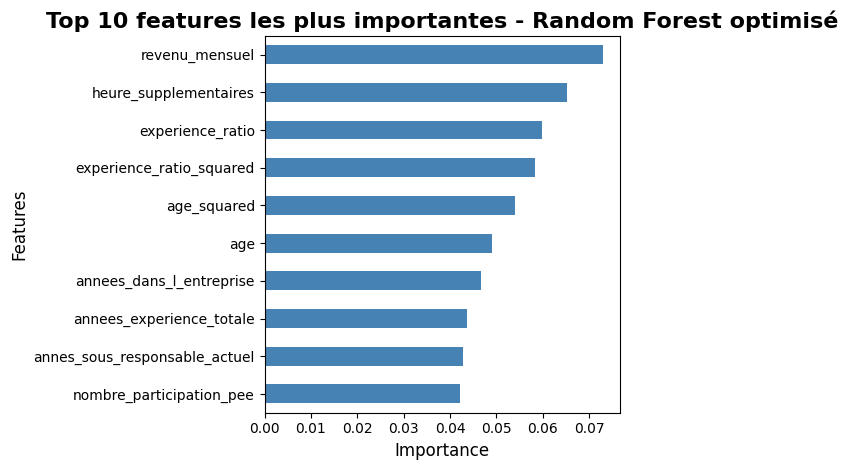

In [39]:
importances = best_rf.feature_importances_

try:
    feat_names = pipeline_tree.get_feature_names_out()
except:
    numerical_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

    num_features = [f"{col}" for col in numerical_cols]
    
    cat_features = []
    for col in categorical_cols:
        unique_vals = X_train[col].unique()
        for val in unique_vals:
            cat_features.append(f"{col}_{val}")
    
    feat_names = num_features + cat_features
  
    if len(feat_names) != len(importances):
        feat_names = [f"feature_{i}" for i in range(len(importances))]

imp_df = pd.DataFrame({
    "Feature": feat_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(12, 8))
imp_df.head(10).plot(kind="barh", x="Feature", y="Importance", legend=False, color='steelblue')
plt.gca().invert_yaxis()
plt.title("Top 10 features les plus importantes - Random Forest optimisé", fontsize=16, fontweight='bold')
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.tight_layout()
plt.show()

### Comparaison des performances et de la stabilité de Random Forest baseline vs GridSearch

Ce graphique permet de comparer la **robustesse** des deux versions du modèle, en vérifiant si l’optimisation par GridSearchCV améliore la régularité des performances.


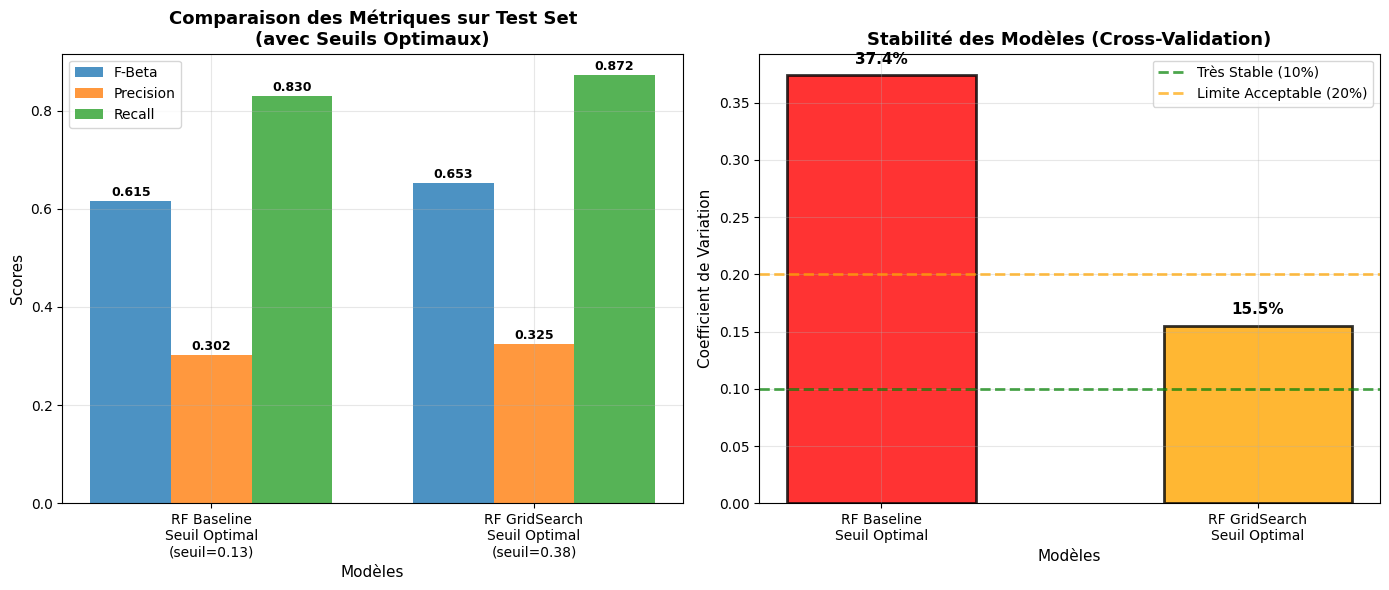

In [40]:
rf_baseline_threshold = best_thresholds['Random Forest']
rf_baseline_proba = rf_proba

rf_baseline_pred_optimal = (rf_baseline_proba >= rf_baseline_threshold).astype(int)

rf_baseline_fbeta_test = fbeta_score(y_test, rf_baseline_pred_optimal, beta=2)
rf_baseline_precision_test = precision_score(y_test, rf_baseline_pred_optimal)
rf_baseline_recall_test = recall_score(y_test, rf_baseline_pred_optimal)

rf_grid_fbeta_test = best_fbeta
rf_grid_precision_test = best_precision
rf_grid_recall_test = best_recall
rf_grid_threshold = best_threshold

rf_baseline_cv_data = cv_df[cv_df['model'] == 'Random Forest']
rf_baseline_fbeta_cv = rf_baseline_cv_data['fbeta_score'].mean()
rf_baseline_fbeta_std_cv = rf_baseline_cv_data['fbeta_score'].std()
rf_baseline_cv_coeff = (rf_baseline_fbeta_std_cv / rf_baseline_fbeta_cv) if rf_baseline_fbeta_cv > 0 else 0

rf_grid_model = RandomForestClassifier(**grid.best_params_, random_state=42, n_jobs=-1)

cv_grid = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_cv_scores = []
grid_precision_scores = []
grid_recall_scores = []

for fold, (train_idx, val_idx) in enumerate(cv_grid.split(X_train_tree, y_train)):
    X_cv_train, X_cv_val = X_train_tree[train_idx], X_train_tree[val_idx]
    y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    rf_grid_model.fit(X_cv_train, y_cv_train)
    
    y_pred = rf_grid_model.predict(X_cv_val)
    
    fbeta = fbeta_score(y_cv_val, y_pred, beta=2)
    precision = precision_score(y_cv_val, y_pred, zero_division=0)
    recall = recall_score(y_cv_val, y_pred, zero_division=0)

    grid_cv_scores.append(fbeta)
    grid_precision_scores.append(precision)
    grid_recall_scores.append(recall)

rf_grid_fbeta_cv = np.mean(grid_cv_scores)
rf_grid_fbeta_std_cv = np.std(grid_cv_scores)
rf_grid_cv_coeff = (rf_grid_fbeta_std_cv / rf_grid_fbeta_cv) if rf_grid_fbeta_cv > 0 else 0


fig, axes = plt.subplots(1, 2, figsize=(14, 6))

models_labels = ['RF Baseline\nSeuil Optimal', 'RF GridSearch\nSeuil Optimal']
x = np.arange(len(models_labels))
width = 0.25

ax = axes[0]

fbeta_scores = [rf_baseline_fbeta_test, rf_grid_fbeta_test]
precision_scores = [rf_baseline_precision_test, rf_grid_precision_test]
recall_scores = [rf_baseline_recall_test, rf_grid_recall_test]

bars1 = ax.bar(x - width, fbeta_scores, width, label='F-Beta', color='#1f77b4', alpha=0.8)
bars2 = ax.bar(x, precision_scores, width, label='Precision', color='#ff7f0e', alpha=0.8)
bars3 = ax.bar(x + width, recall_scores, width, label='Recall', color='#2ca02c', alpha=0.8)


for i, (fb, pr, rc) in enumerate(zip(fbeta_scores, precision_scores, recall_scores)):
    ax.text(i - width, fb + 0.01, f'{fb:.3f}', ha='center', fontsize=9, fontweight='bold')
    ax.text(i, pr + 0.01, f'{pr:.3f}', ha='center', fontsize=9, fontweight='bold')
    ax.text(i + width, rc + 0.01, f'{rc:.3f}', ha='center', fontsize=9, fontweight='bold')


ax.set_xlabel('Modèles', fontsize=11)
ax.set_ylabel('Scores', fontsize=11)
ax.set_title('Comparaison des Métriques sur Test Set\n(avec Seuils Optimaux)', 
             fontweight='bold', fontsize=13)
ax.set_xticks(x)
ax.set_xticklabels([f'{name}\n(seuil={t:.2f})' 
                     for name, t in zip(models_labels, [rf_baseline_threshold, rf_grid_threshold])], 
                    fontsize=10)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

ax = axes[1]
cv_coefficients = [rf_baseline_cv_coeff, rf_grid_cv_coeff]
colors_stability = []

for cv_coeff in cv_coefficients:
    if cv_coeff < 0.10:
        colors_stability.append('green')
    elif cv_coeff < 0.20:
        colors_stability.append('orange')
    else:
        colors_stability.append('red')

bars = ax.bar(range(len(models_labels)), cv_coefficients, color=colors_stability, 
              alpha=0.8, edgecolor='black', linewidth=2, width=0.5)

for i, cv_coeff in enumerate(cv_coefficients):
    ax.text(i, cv_coeff + 0.01, f'{cv_coeff:.1%}',
            ha='center', fontsize=11, fontweight='bold')

ax.axhline(y=0.10, color='green', linestyle='--', alpha=0.7, linewidth=2, label='Très Stable (10%)')
ax.axhline(y=0.20, color='orange', linestyle='--', alpha=0.7, linewidth=2, label='Limite Acceptable (20%)')

ax.set_xlabel('Modèles', fontsize=11)
ax.set_ylabel('Coefficient de Variation', fontsize=11)
ax.set_title('Stabilité des Modèles (Cross-Validation)', fontweight='bold', fontsize=13)
ax.set_xticks(range(len(models_labels)))
ax.set_xticklabels([name.replace(' Seuil Optimal', '\nSeuil Optimal') for name in models_labels], 
                    fontsize=10)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Interprétation des prédictions avec SHAP

SHAP attribue une contribution à chaque feature pour expliquer la prédiction d’un modèle complexe.  

Il fournit des explications locales (pour une observation) et globales (pour l’ensemble du jeu de données), permettant de comprendre **pourquoi un modèle prédit un certain résultat**.

#### Graphique Waterfall
- Visualise l’explication **locale** pour une observation précise.  
- Ici, l’observation choisie correspond à un employé qui a quitté l’entreprise.  
- Chaque barre montre l’impact d’une feature sur la prédiction par rapport à la valeur de base

- Permet de comprendre quelles variables ont poussé la probabilité de départ à augmenter ou diminuer pour cette personne.

#### Graphique Beeswarm
- Visualisation **globale** sur l’ensemble des observations.  
- Chaque point représente l’impact d’une feature pour une observation individuelle.  
- Permet de repérer les features les plus influentes et la distribution de leurs effets sur le modèle.  
- Limité ici aux 10 features les plus importantes pour lisibilité.

Dans les graphiques SHAP :

- **Rouge** : la valeur de la feature **pousse la prédiction vers la classe positive** (ici, augmenter la probabilité que l’employé quitte l’entreprise).  
- **Bleu** : la valeur de la feature **pousse la prédiction vers la classe négative** (ici, réduire la probabilité de départ).

Ainsi, chaque point ou barre indique non seulement l’importance de la feature mais aussi **la direction de son effet** sur la prédiction.



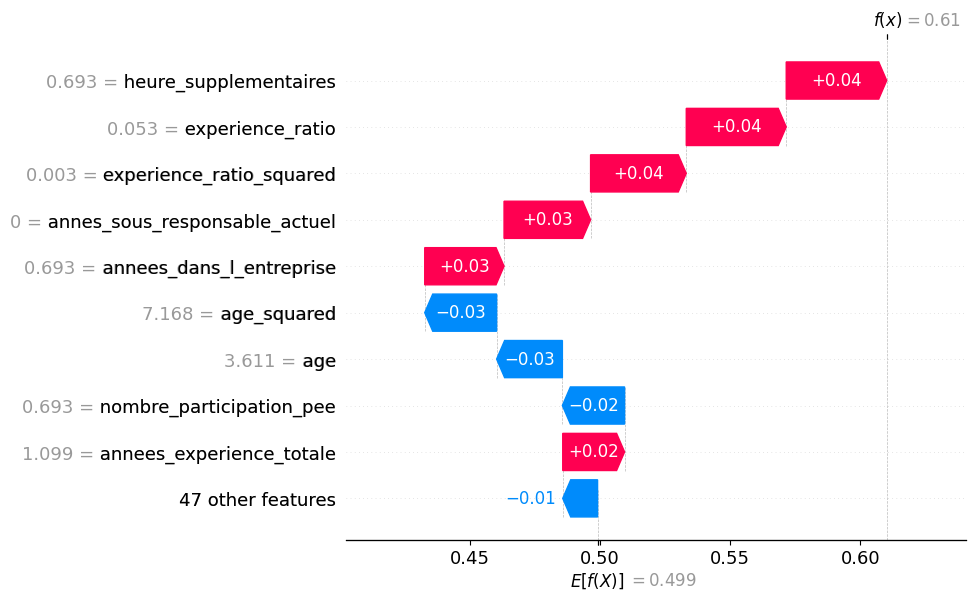

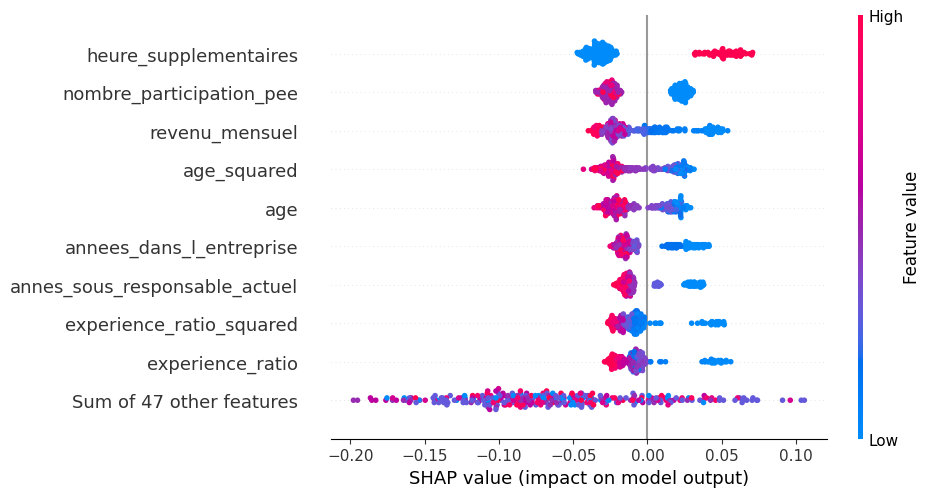

In [41]:
numerical_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

num_feature_names = [f"{col}" for col in numerical_cols]

cat_feature_names = []
for col in categorical_cols:
    unique_values = sorted(X_train[col].unique())

    for val in unique_values[1:]:
        cat_feature_names.append(f"{col}_{val}")

all_feature_names = num_feature_names + cat_feature_names

n_features = X_test_tree.shape[1]
if len(all_feature_names) != n_features:
    if len(all_feature_names) < n_features:
        all_feature_names += [f"feature_{i}" for i in range(len(all_feature_names), n_features)]
    else:
        all_feature_names = all_feature_names[:n_features]

X_test_df = pd.DataFrame(
    X_test_tree,
    columns=all_feature_names
)

explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test_df)

if isinstance(shap_values, list) and len(shap_values) == 2:
    shap_values = shap_values[1] 
elif isinstance(shap_values, np.ndarray):
    if len(shap_values.shape) == 3: 
        shap_values = shap_values[:, :, 1]

if isinstance(explainer.expected_value, list):
    base_value = explainer.expected_value[1]
elif isinstance(explainer.expected_value, np.ndarray) and len(explainer.expected_value) > 1:
    base_value = explainer.expected_value[1]
else:
    base_value = explainer.expected_value

idx_depart = 4

shap.plots.waterfall(shap.Explanation(
    values=shap_values[idx_depart],
    base_values=base_value,
    data=X_test_df.iloc[idx_depart],
    feature_names=all_feature_names
))

shap.plots.beeswarm(shap.Explanation(
    values=shap_values,
    base_values=base_value,
    data=X_test_df.values,
    feature_names=all_feature_names
), max_display=10)

### Impact de la réduction des variables sur les performances du Random Forest

Cette analyse évalue comment la **sélection des features les plus importantes** influence les performances du modèle.

1. Les **features sont triées** par importance décroissante selon le Random Forest optimisé.  
2. Différents pourcentages de features sont conservés : 80%, 60%, 50%.
3. Le modèle est entraîné avec les **paramètres optimaux** du GridSearch.  
4. Les prédictions sont faites avec le **seuil optimal**, et les métriques F-Beta, précision et rappel sont calculées.

- **Évaluer la robustesse** : vérifier si le modèle conserve des performances similaires même avec moins de variables.  
- **Réduction de complexité** : diminuer le nombre de variables peut réduire le temps de calcul et améliorer l’interprétabilité sans sacrifier significativement la performance.  



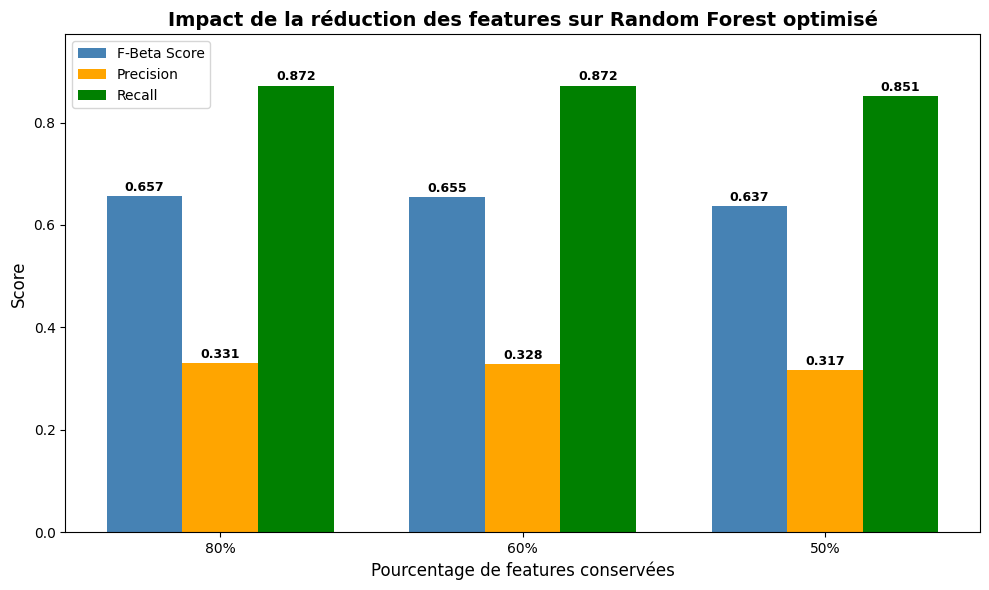

In [42]:
feature_importances = best_rf.feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1]

percentages = [80, 60, 50]
results = []

for pct in percentages:
    n_features = int(len(feature_importances) * pct / 100)
    top_features = sorted_idx[:n_features]
    
    X_train_selected = X_train_tree[:, top_features]
    X_test_selected = X_test_tree[:, top_features]

    
    rf_reduced = RandomForestClassifier(
        n_estimators=best_rf.n_estimators,
        max_depth=best_rf.max_depth,
        min_samples_split=best_rf.min_samples_split,
        min_samples_leaf=best_rf.min_samples_leaf,
        max_features=best_rf.max_features,
        max_samples=best_rf.max_samples,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'
    )
    rf_reduced.fit(X_train_selected, y_train)
    
    y_proba = rf_reduced.predict_proba(X_test_selected)[:, 1]
    y_pred = (y_proba >= best_threshold).astype(int)
    
    fbeta = fbeta_score(y_test, y_pred, beta=2)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    
    results.append({
        'Pourcentage features': f"{pct}%",
        'Nb features': n_features,
        'F-Beta Score': fbeta,
        'Precision': precision,
        'Recall': recall
    })

results_df = pd.DataFrame(results)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

x_pos = range(len(results_df))
width = 0.25

bars1 = ax.bar([i - width for i in x_pos], results_df['F-Beta Score'], width=width, label='F-Beta Score', color='steelblue')
bars2 = ax.bar(x_pos, results_df['Precision'], width=width, label='Precision', color='orange')
bars3 = ax.bar([i + width for i in x_pos], results_df['Recall'], width=width, label='Recall', color='green')

for i, (fb, pr, rc) in enumerate(zip(results_df['F-Beta Score'], results_df['Precision'], results_df['Recall'])):
    ax.text(i - width, fb + 0.01, f'{fb:.3f}', ha='center', fontsize=9, fontweight='bold')
    ax.text(i, pr + 0.01, f'{pr:.3f}', ha='center', fontsize=9, fontweight='bold')
    ax.text(i + width, rc + 0.01, f'{rc:.3f}', ha='center', fontsize=9, fontweight='bold')

ax.set_xticks(x_pos)
ax.set_xticklabels(results_df['Pourcentage features'])
ax.set_xlabel('Pourcentage de features conservées', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Impact de la réduction des features sur Random Forest optimisé', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.set_ylim(0, max(results_df['Recall'].max(), results_df['F-Beta Score'].max(), results_df['Precision'].max()) + 0.1)
plt.tight_layout()
plt.show()

### Conclusion sur les résultats du modèle

Le Random Forest optimisé s’impose comme le modèle le plus performant dans notre étude, offrant des métriques très satisfaisantes (F-Beta, précision, rappel) et une **stabilité plus qu’acceptable**.  

La réduction du nombre de variables n’a que peu impacté les performances, ce qui confirme que le modèle reste **fiable même avec un jeu de features plus restreint**. Cette caractéristique est un atout pour le **déploiement futur**, réduisant la complexité, le coût de calcul et facilitant l’interprétation.

L’analyse des importances de variables et des explications SHAP révèle que les principaux facteurs associés au départ des employés sont :
- **Les heures supplémentaires**  
- **L’âge de l’employé**  
- **Le revenu mensuel**  

Ces données permettent non seulement de prédire les risques de départ avec précision, mais aussi de guider des actions RH ciblées.
